# Tooplox - Data Science Exercise 

In this notebook we would solve a Tooploox Data Science Exercise according to instructions in the *exercise_description.pdf* provided in the root folder of this notebook.

Let's start with loading data:

In [1]:
import pandas

main_dataset = pandas.read_csv("data.csv", header = None)

Let's have a glance at main statistics of main datasets columns:

In [2]:
print main_dataset.describe()

                 1              2             3             4             5    \
count     916.000000     916.000000  9.160000e+02  9.160000e+02  9.160000e+02   
mean    39889.541485   69421.946507  9.253133e+04  1.127782e+05  1.314772e+05   
std     24816.900947   58148.785461  9.892775e+04  1.442615e+05  1.924524e+05   
min         0.000000    3886.000000  8.608000e+03  9.396000e+03  9.989000e+03   
25%     23913.250000   38524.250000  4.782550e+04  5.549100e+04  6.192675e+04   
50%     34947.500000   56115.000000  7.026300e+04  8.120050e+04  9.110750e+04   
75%     50530.500000   84617.750000  1.088968e+05  1.300948e+05  1.475098e+05   
max    189528.000000  973903.000000  1.737730e+06  2.518686e+06  3.306221e+06   

                6             7             8             9             10   \
count  9.160000e+02  9.160000e+02  9.160000e+02  9.160000e+02  9.160000e+02   
mean   1.487397e+05  1.647916e+05  1.801862e+05  1.951114e+05  2.094496e+05   
std    2.390413e+05  2.832962e+05

## 1. Let's analyse $V(n)$ for $n = 24, 72, 168$.

Let's start with plotting main statistics for this columns:

In [3]:
print main_dataset[[24, 72, 168]].describe()

                24            72            168
count  9.160000e+02  9.160000e+02  9.160000e+02
mean   3.767655e+05  6.133033e+05  7.432098e+05
std    9.236467e+05  1.653969e+06  2.007964e+06
min    2.117300e+04  2.616200e+04  2.713900e+04
25%    1.248655e+05  1.483262e+05  1.533462e+05
50%    1.943575e+05  2.374175e+05  2.522870e+05
75%    3.266670e+05  4.336122e+05  5.222592e+05
max    1.528464e+07  2.291670e+07  2.789824e+07


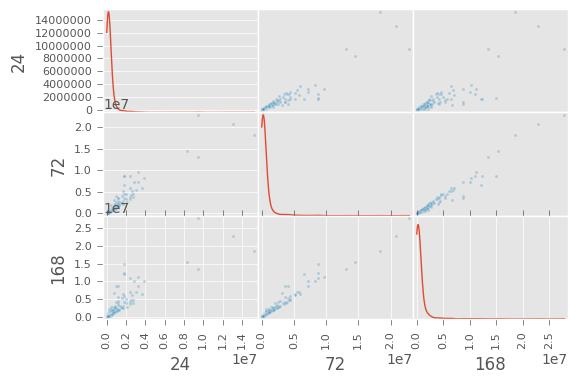

In [5]:
from matplotlib import pyplot as plt
from pandas.tools.plotting import scatter_matrix

plt.style.use('ggplot')

scatter_matrix(main_dataset[[24, 72, 168]], diagonal = 'kde', alpha = 0.3)
plt.show()

From the correlation matrix plotted above one can notice two things: enormous correlation of this columns and a $log-normal$ distribution density.